# Introduction-Data-Science Task 3

Lena Breitberg, Doreen Mack, David Riethmann

---

# Imports

In [1]:
import itertools

import pandas as pd
import xgboost as xgb
import seaborn as sns
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import sklearn.model_selection as sms
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

In [2]:
# Trainingsdaten
train_data = pd.read_csv('../data/train_data_task2.csv')

# Validierungsdaten
validation_data = pd.read_csv('../data/validation_data_task2.csv')

# Testdaten
test_data = pd.read_csv('../data/test_data_task2.csv')

# Performance Measures

In [3]:
def performance_measures(y_true, y_pred, n_predictors) -> tuple:
    """
    Calculate R2, Adjusted R2, and MAE
    
    Args:
        y_true: array-like, True values
        y_pred: array-like, Predicted values
        n_predictors: int, number of predictors used in the model excluding the intercept
        
    Returns:
        r2: float, R2 score
        adjusted_r2: float, Adjusted R2 score
        mae: float, Mean Absolute Error
    """
    n = len(y_true)  # Number of observations
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_predictors - 1))
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    measures = {
        "R2": r2,
        "Adjusted_R2": adjusted_r2,
        "MAE": mae,
        "RMSE": rmse
    }

    print(f"R2: {r2:.2f}")
    print(f"Adjusted R2: {adjusted_r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return measures



In [4]:
def actualVsPredictChart(true_v, pred_v, model: str = ""):
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    # Create a lineplot with Seaborn
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title(f"{model} Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

# 1 Baseline Model

In [5]:
baseline_model = LinearRegression()

In [6]:
baseline_model.fit(train_data.drop(["cnt"], axis=1), train_data["cnt"])

LinearRegression()

In [7]:
y_pred = baseline_model.predict(validation_data.drop(["cnt"], axis=1))

In [8]:
measures = performance_measures(validation_data["cnt"], y_pred, len(baseline_model.coef_))

R2: 0.86
Adjusted R2: 0.83
MAE: 599.93
RMSE: 742.24


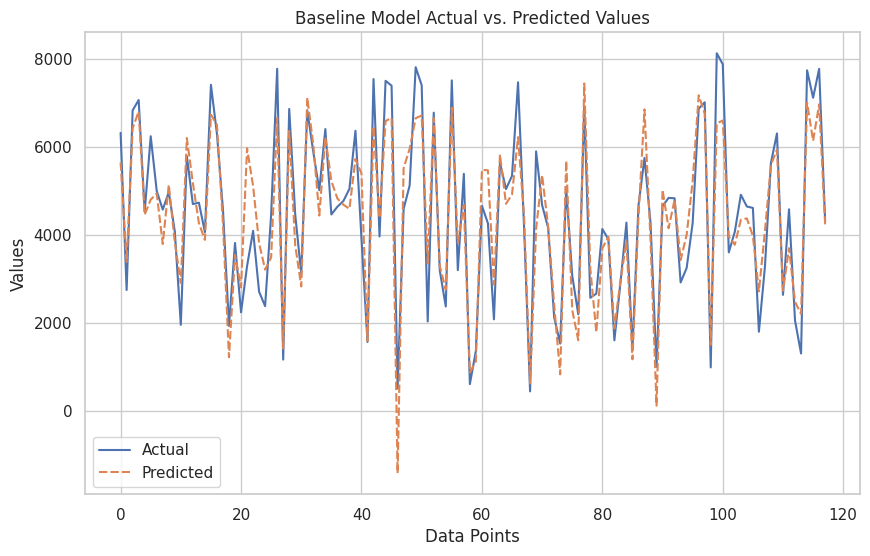

In [9]:
actualVsPredictChart(validation_data["cnt"], y_pred, "Baseline Model")

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# 2 Initial Model Selection

Für die Evaluierung verschiedener Algorithmen nutzen wir die Bibliothek Lazy Predict bzw. aus dieser Bibliothek den Lazy Regressor. Diese wurde von Shankar Rao Pandala entwickelt. Es handelt sich um eine Wrapper-Bibliothek, die auf vielen verschiedenen Machine Learning Bibliotheken und -Algorithmen basiert.
Der Lazy Regressor automatisiert den Auswahlprozess geeigneter Regressionsmodelle, indem eine Vielzahl von Modellen auf den vorliegenden Datensatz angewandt wird. Dieser wird zuvor durch minimales Preprocessing für den Auswahlprozess vorbereitet z.B. mittels Scaling und Imputation. 
Im Anschluss werden die Modelle anhand der gängigen Metriken, in unserem Fall R-Squared und MAE bewertet. Es ist wichtig zu beachten, dass kein automatisiertes Hyperparamter Tuning durchgeführt wird.
Dieses Vorgehen bietet vor allem den Vorteil, dass des gesamte Prozess automatisiert abläuft und die Bibliothek sehr einfach anzuwenden ist. Zusätzlich wird eine erhebliche Zeitersparnis ermöglicht.

In [ ]:
lazy_regressor = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = lazy_regressor.fit(train_data.drop(['cnt'], axis=1), validation_data.drop(['cnt'], axis=1), train_data['cnt'], validation_data['cnt'])

In diesem DataFrame sind die Metriken der jeweiligen Modelltypen zu sehen. Zu erkennen ist, dass der Typ `GradientBoostingRegressor` nach allen Metriken den höchsten Wert für Adjusted R-Squared erzielt. Weitere gut abschneidende Modelltypen sind der `XGBRegressor` und der `ExtraTreesRegressor`. Für das Parametertuning werden alle drei Typen näher betrachtet, da es sein könnte, dass eines der drei Modelle deutlich besser abschneidet, sobald die Hyperparameter angepasst werden. Den Modelltyp `HistGradientBoostingRegressor` werden wir nicht verwenden, da dieser besonders ähnliche Eigenschaften aufweist, wie der `GradientBoostingRegressor`.

In [ ]:
models

Auf dieser Grafik ist ein Vergleich zwischen tatsächlichen und vorhergesagten Daten des `GradientBoostingRegressor` zu sehen. Es ist zu erkennen, dass es einige Ausreißer nach unten gibt, die das Modell nicht abbilden konnte. Bei dem Wert am rechten Ende des Graphen konnte das Modell dies jedoch sehr gut.

In [ ]:
for model_name in models.iloc[: 3].index:
    y_pred = predictions[model_name].to_list()
    measures = performance_measures(validation_data['cnt'], y_pred, n_predictors=validation_data.drop(['cnt'], axis=1).shape[1])
    actualVsPredictChart(validation_data['cnt'], y_pred, model=model_name)

## 4 Hyperparamter Tuning

Im Folgenden probieren wir verschiedene Kombinationen von Hyperparametern für die drei ausgewählten Algorithmen aus, um jeweils die beste Leistung des Modells zu erzielen.

### 4.1 GradientBoostingRegressor

- **Loss**: Loss bezeichnet das Verlustmaß. Dieses soll minimiert werden. Wir verwenden die Methode "quantile" d.h. die Quantilregression. Hierdurch wird der quantile Fehler minimiert, was zu robusteren Regressionen führen kann. Desweiteren stehen die Methoden squared_error (Minimierung des mittleren quadratischer Fehlers zwischen vorhergesagten und tatsächlichen Werten), absolute_error (Minimierung des mittleren absoluten Fehlers zwischen vorhergesagten und tatsächlichen Werten) sowie huber (Kombination aus quadratischem und absolutem Fehler) zur Auswahl.
- **Alpha**: Der Alpha-Wert beeinflusst die Gewichtung der Residuals in der Quantilregression. Durch die Variation von alpha kann der Fokus auf unterschiedliche Quantile gelegt werden. Wir verwenden eine Liste von Werten von 0.2 bis 0.8 in Schritten von 0.2.
- **Criterion**: Hiermit ist das Kriterium gemeint, das zur Auswahl der besten Aufteilung in jedem Entscheidungsbaumknoten verwendet wird. In diesem Fall werden 'friedman_mse' und 'squared_error' verwendet. 'friedman_mse' ist eine verbesserte Version des mittleren quadratischen Fehlers (MSE) für Gradient Boosting.
- **Learning Rate**: Die Lernrate steuert, wie stark jeder Baum die vorherigen Bäume korrigiert. Eine niedrige Lernrate erfordert im Normalfall mehr Bäume, um den gleichen Effekt zu erzielen, kann jedoch im Gegenzug zu einer besseren Generalisierung führen. Hier werden Werte von 0.1 bis 0.5 in Schritten von 0.1 verwendet.
- **Max Depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte None, 5 und 10. None bedeutet, dass es keine festgelegte maximale Tiefe gibt.
- **Number of Estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. Wir legen die Werte 50, 100 und 200 zur Auswahl fest.

### 4.2 XGBRegressor

- **Number of Estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. Wir legen die Werte 50, 100 und 200 zur Auswahl fest.
- **Max Depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte None, 5 und 10. None bedeutet, dass es keine festgelegte maximale Tiefe gibt.
- **Max Leaves**: Max Leaves meint die maximale Anzahl von Blättern in einem Baum und begrenzt das Wachstum der Bäume.
- **Learning Rate**: Die Lernrate steuert, wie stark jeder Baum die vorherigen Bäume korrigiert. Eine niedrige Lernrate erfordert im Normalfall mehr Bäume, um den gleichen Effekt zu erzielen, kann jedoch im Gegenzug zu einer besseren Generalisierung führen. Hier werden Werte von 0.1 bis 0.5 in Schritten von 0.1 verwendet.
- **Booster**: Hier wird die Art des Boosters, der verwendet wird, festgelegt. "gbtree" steht für Entscheidungsbäume, "gblinear" für lineare Modelle und "dart" für Dropout-gestützte Entscheidungsbäume.
- **Grow Policy**: Die Grow Policy legt die Strategie für das Wachstum der Bäume fest. 0 steht für "depthwise", 1 für "lossguide". Bei "depthwise" wächst der Baum schichtweise, wohingegen "lossguide" eine strukturiertere Wachstumsrichtlinie basierend auf dem Verlust verwendet.
- **Gamma**: Dieser Paramter gibt an, wie stark ein Baumzweig, basierend auf dem Verlustrückgang, geschnitten wird. Ein höherer Gamma-Wert führt zu konservativerem Pruning.
- **Regularization Alpha**: Hiermit ist der L1 Regularisierungsterm auf den Gewichtungen der Blätter gemeint. Dieser hilft bei der Vermeidung von Overfitting durch Sparsamkeit.
- **Regularization Lambda**: Dieser Parameter meint den L2 Regularisierungsterm auf den Gewichtungen der Blätter und hilft bei der Vermeidung von Overfitting durch Schrumpfung der Gewichtungen.
- **Metric**: Metric meint die Bewertungsmetrik, die während des Trainings verwendet wird. Wir verwenden hier den Mean Absolute Error (skm.mean_absolute_error) als Bewertungsmetrik.

### 4.3 ExtraTressRegressor

- **Number of Estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. Wir legen die Werte 50, 100 und 200 zur Auswahl fest.
- **Criterion**: Criterion wählt das Kriterium aus, das zur Auswahl der besten Aufteilung in jedem Entscheidungsbaumknoten verwendet wird ,z.B. squared_error (mittlerer quadratischer Fehler), absolute_error (mittlerer absoluter Fehler), friedman_mse (verbesserte MSE für Gradient Boosting) oder poisson (Poisson-Regression für Zählvariablen).
- **Max Features**: Dieser Paramter definiert die maximale Anzahl der Merkmale, die für die Suche nach der besten Aufteilung in einem Baumknoten verwendet werden, z.B. sqrt (Quadratwurzel der Anzahl der Merkmale) oder log2 (Logarithmus zur Basis 2 der Anzahl der Merkmale):
- **Max Depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte None, 5 und 10. None bedeutet, dass es keine festgelegte maximale Tiefe gibt.

### 4.4 Auswahl der optimalen Hyperparamter

Im Folgenden werden alle Hyperparameter definiert. Die Listen enthalten die möglichen Werte eines jeden Parameters. Jedes Modell hat verschiedene Hyperarameter zur Auswahl, die bereits vorgestellt wurden.

In [ ]:
gbRegressor = {
    "loss": ['squared_error'],#, 'absolute_error', 'huber', 'quantile'],
    "alpha": [0.2*x for x in range(1, 5)],
    "criterion": ['friedman_mse', 'squared_error'],
    "learning_rate": [0.1*x for x in range(-2, 3)],
    "max_depth": [None, 5, 10],
    "n_estimators": [50, 100, 200]
}

xgbRegressor = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "max_leaves": [0, 5, 10, 20],
    "learning_rate": [0.2*x for x in range(1, 5)],
    "booster": ["gbtree", "gblinear", "dart"],
    "grow_policy": [0, 1],
    "gamma": [1e-3, 1e-1, 1],
    "reg_alpha": [1e-3, 1e-1, 1],
    "reg_lambda": [1e-3, 1e-1, 1],
    "metric": [mean_absolute_error]
}

etRegressor = {
    "n_estimators": [50, 100, 200],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 3, 5, 10]
}

features = {
    ske.GradientBoostingRegressor: gbRegressor,
    xgb.XGBRegressor: xgbRegressor,
    ske.ExtraTreesRegressor: etRegressor
}

Mit Hilfe von `GridSearchCV` wird ein Hyperparameter-Tuning für jedes Modell durchgeführt, um jeweils die beste Kombination von Hyperparametern zu finden. Hierbei verwenden wir den negativen Mean Absolute Error als Bewertungsmetrik. Eine automatische Kreuzvalidierung findet ebenfalls statt.

In [ ]:
model_select_results = pd.DataFrame(columns=["model", "params", "mae"])


for model_type in features:
    gs_model = sms.GridSearchCV(estimator=model_type(random_state=1),
                                param_grid=features[model_type],
                                n_jobs=-1,
                                scoring='neg_mean_absolute_error')

    gs_model.fit(train_data.drop(["cnt"], axis=1), train_data["cnt"])
    print(f"Model type {model_type.__name__}\nreached MAE of {gs_model.best_score_*-1}\n Params: {gs_model.best_params_}")
    model_select_results.loc[len(model_select_results)] = [type(gs_model.best_estimator_), gs_model.best_params_, gs_model.best_score_*-1]

model_select_results.sort_values("mae", ignore_index=True, inplace=True)

In [ ]:
model_select_results

Das Modell mit dem besten Ergebnis ist der `XGBRegressor`. Der MAE beträgt 670.95 für folgende Hyperparamter:

In [ ]:
model_select_results.at[1, "params"]

## Feature Selection ##

Diese Funktion gibt alle möglichen, einzigartigen Kombinationen der unabhängigen Variablen aus. Die Liste enthält die höchste Anzahl an Features zu Beginn und wird danach immer kürzer (Backward Eliminiation).

In [ ]:
def get_feature_combinations(features, length):
    all_combinations = []
    for r in range(1, length + 1):
        combinations = itertools.combinations(features, r)
        all_combinations.extend(combinations)

    # Backwards Elimination
    return all_combinations[::-1]

Diese Funktion nimmt eine Liste von Indexes auf und gibt die Liste der numerischen Indexes zurück. Dies wird benötigt, da die `numpy`-Arrays nach der Skalierung numerische Indexes verwenden. Um auf bestimmte Features zuzugreifen, wird der numerische Index gebraucht.

Funktion zur Evaluation einer Feature-Kombination mittels MAE.

In [ ]:
def eval_model_params(features):
    reg = Ridge(random_state=1)
    reg.fit(train_data[features], train_data["cnt"])

    y_pred = reg.predict(validation_data[features])
    mae = mean_absolute_error(validation_data["cnt"], y_pred)
    coefs = reg.coef_
    reg

    return dict(features=features,
                coefs=coefs,
                mae=mae)

Vorgehensweise:
- Es wird über alle möglichen Feature-Kombinationen iteriert und ein `Ridge`-Regressionsmodell erstellt. `Ridge` wird verwendet, da die `LinearRegression` Probleme mit overfitting verursacht.
- Die verwendeten Features, die Koeffizienten, sowie der MAE werden in einem DataFrame gespeichert.

In [ ]:
num_of_features = len(features)
feature_list = get_feature_combinations(features, num_of_features)
c = 0
print("Feature combinations", len(feature_list))

Insgesamt gibt es ca. 4,2 Mio. einzigartige Kombinationen der Features. Für jede Kombination wird ein grundlegendes Modell erstellt und dessen MAE, sowie die Parameterkombination gespeichert.

In [ ]:
feature_results = [{"mae": 0}]
num_of_features = len(features)
feature_list = get_feature_combinations(features, num_of_features)
c = 0
print("Feature combinations", len(feature_list))
for feature_comb in feature_list:
    feature_results.append(eval_model_params(feature_comb))

    c+=1

    if c % 500 == 0:
        print(f"Evaluating {len(feature_comb)}/{len(features)} feature combinations (No. {c}) - MAE: {feature_results[-1]['mae']}", end="\r")

feature_results.remove({"mae": 0})

In [ ]:
feature_results = pd.DataFrame(feature_results).sort_values("mae", ignore_index=True).dropna()

Die besten Ausführungsergebnisse speichern.

In [ ]:
#feature_results.loc[:10000, :].to_csv("feature_results.csv")

Eigenschaften der besten Modelle, sortiert nach dem MAE. Jede Zeile in dem DataFrame ist das Ergebnis eines Modells mit einer einzigartigen Feature-Kombination.

In [ ]:
feature_results

Features des besten Modells, nach MAE gewertet

In [ ]:
feature_results.iat[0, 0]

Um die Koeffizienten den jeweiligen Features zuordnen zu können, erstellen wir dafür ein separates DataFrame. Die Koeffizienten sind deshalb wichtig, da sie aussagen, wie wichtig ein Feature für eine genaue Vorhersage ist. Da die Daten bereits skaliert sind, sind alle Werte im Bereich [-1;1] und es gibt keine Gewichtungsunterschiede zwischen den Features.

In [ ]:
reg_dicts = []

for idx, row in feature_results.iterrows():
    reg_dicts.append({key: value for key, value in zip(row["features"], row["coefs"])})
coef_df = pd.DataFrame(data=reg_dicts)

Durchschnittliche Koeffizienten der jeweiligen Features im `Ridge`-Regressionsmodell

Erkenntnisse:
- Die gefühlte Temperatur hat einen relativ hohen Einfluss auf die Kundenzahl
- An Feiertagen sind ca. 100 Kunden weniger unterwegs
- Werbeblätter haben einen negativen Einfluss (Vielleicht doch weglassen?)
- Eine Preisreduktion hat nur wenig Einfluss auf die Kundenzahl
- Im Winter gibt es weitaus weniger Kunden, sonst gibt es keinen signifikaten Unterschied zwischen den Jahreszeiten
- Die Wetterbedingungen haben eine entsprechende Auswirkung
- Von Montag bis Mittwoch gibt es täglich weniger Kunden als an anderen Wochentagen
- Je stärker die Windgeschwindigkeit, desto weniger Fahrräder werden gemietet
- An Werktagen sind ca. 130 Kunden mehr unterwegs, was darauf hindeutet, dass diese Kunden Arbeitspendler sind
- Im Flgejahr gibt täglich 1000 Kunden mehr, als im Erstjahr (Kundenzuwachs)

Koeffiziententabelle speichern

In [ ]:
#coef_df.describe().round(2).T.sort_index().to_csv("coefficients.csv")

## Final Model ##

In [ ]:
def build_model(mtype, features, params):

    fin_model = mtype(random_state=1, **params)

    fin_model.fit(X_train, y_train)

    y_pred = fin_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return [mtype.__name__, mae, r2, fin_model, params]

In [ ]:
fin_features = feature_results.iat[0, 0]

In [ ]:
fin_models = pd.DataFrame(columns=["modeltype", "mae", "r2", "model", "params"])
for idx, row in model_select_results.iterrows():
    fin_models.loc[len(fin_models)] = build_model(row["model"], fin_features, row["params"])

In [ ]:
fin_models

In [ ]:
fin_models.loc[1, "params"]

**Modelltyp**
- `sklearn.ensemble.GradientBoostingRegressor`

**Hyperparameter**
- Alpha: `0.2`
- Messkriterium: `friedman_mse`
- Lernrate: `0.1`
- Loss: `squared_error`
- Maximale Baumtiefe: `5`
- Anzahl Regressoren: `100`

**Verwendete Features**
- `yr`
- `mnth`
- `workingday`
- `atemp`
- `leaflets`
- `weekday_4`
- `weekday_5`
- `weekday_6`
- `season_1`
- `season_4`
- `weathersit_1`
- `weathersit_2`

In [ ]:
#pickle.dump(fin_models.at[1, "model"], open("../models/final_model_optimized.pkl"))